<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI LRS Slit Mode Pipeline Notebook #

**Authors**: Ian Wong; MIRI branch<br>
**Last Updated**: May 5, 2025<br>
**Pipeline Version**: 1.18.0 (Build 11.3)

**Purpose**:<BR>
This notebook provides a framework for processing generic Mid-Infrared
Instrument (MIRI) Low Resolution Spectroscopy (LRS) slit mode data through all
three James Webb Space Telescope (JWST) pipeline stages.  The data are assumed
to be located in the observation directory located in the path set up below. 
It should not be necessary to edit any cells other than in the [Configuration](#1.-Configuration) section unless modifying the standard pipeline processing options.

**Data**:<BR>
This example is set up to use observations of the A-type standard star BD+60 1753, which were obtained as part of the Cycle 1 JWST flux calibration campaign by Proposal ID (PID) 1536 Observation 27. The target is a
point source that is dithered within the slit using the standard 2-point along-slit nod pattern. The two dithered observations will be used together to remove the background flux.
The example uncalibrated data will be downloaded automatically unless
disabled (i.e., to run with user-supplied local files instead).

**JWST pipeline version and CRDS context**:<BR>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.** Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data#gsc.tab=0) for this build are noted in the notebook.<BR>

**Updates**:<BR>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
Feb 1 2025: Notebook created.<br>
May 5, 2025: Updated to jwst 1.18.0 (no significant changes)

<hr style="border:1px solid gray"> </hr>

## Table of Contents

1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector1 Pipeline](#5.-Detector1-Pipeline)
6. [Spec2 Pipeline](#6.-Spec2-Pipeline)
7. [Spec3 Pipeline](#7.-Spec3-Pipeline)
8. [Plot the spectrum](#8.-Plot-the-spectrum)

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration<a class="anchor" id="intro"></a>
------------------
### Install dependencies
To make sure that the pipeline version is compatabile with this notebook and the required dependencies and packages are installed,
it is recommended that users create a new dedicated conda environment and install the provided
`requirements.txt` file before starting this notebook: <br>
```
conda create -n lrs_demo python=3.11
conda activate lrs_demo
pip install -r requirements.txt
```

### Set run parameters
Set basic parameters to use with the notebook. These will affect
what observation is used, where the uncalibrated data are located (if already on disk), which
pipeline modules to run on the data, and whether background subtraction is carried out. The list of parameters are:

* demo_mode
* directory with data
* pipeline steps
* bkg_sub

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this mode, this
notebook will download the example data from the
Barbara A. Mikulski Archive for Space Telescopes ([MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)) and process them through the pipeline.
All input and output data will be stored in the local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> to process user-specified data that have already
been downloaded and provide the location of the data.<br>

The <code>bkg_sub</code> flag instructs the pipeline whether to carry out nod subtraction (i.e., A-B subtraction) to remove the background flux from each exposure. This is the default treatment for slit mode observations that use the standard nod pattern.

In [2]:
# Set parameters for demo_mode, data directory, and processing steps

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to the user's local directory setup (paths below are given as
    # examples).
    basedir = os.path.join(os.getcwd(), '')

    # Point to where the observation data are stored.
    # Assumes uncalibrated data in obs_dir/uncal/, with results stored in stage1,
    # stage2, stage3 directories.
    obs_dir = os.path.join(basedir, 'PID01536Obs027/')

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Pipeline processing
do_det1 = True  # calwebb_detector1
do_spec2 = True  # calwebb_spec2
do_spec3 = True  # calwebb_spec3
do_viz = True  # Visualize calwebb_spec3 results

# Background subtraction
bkg_sub = True  # Set as true to carry out nod subtraction for background removal (recommended)

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache directory has not been set already, it will be automatically created in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1322.pmap'  # CRDS context for 1.17.1

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory.
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
    
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Print out CRDS path and context that will be used
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2.<font color='white'>-</font>Package Imports<a class="anchor" id="intro"></a>

Automatically import necessary Python packages for use in the data processing and visualization.

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
from pathlib import Path

# Numpy for doing calculations
import numpy as np

# -----------------------Astropy Imports-----------------------------------
# Astropy utilities for opening FITS and ASCII files and downloading demo files
from astropy.io import fits

# -----------------------Astroquery Imports-----------------------------------
from astroquery.mast import Observations

# -----------------------Plotting Imports----------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
# --------------JWST Calibration Pipeline Imports---------------------------
# Import the base JWST and calibration reference data packages
import jwst
import crds

# JWST pipelines (each encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
#from jwst import datamodels  # JWST datamodels
#from jwst.stpipe import Step  # Import the wrapper class for pipeline steps
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

# Print out pipeline version and CRDS context that will be used
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

JWST Calibration Pipeline Version = 1.18.0


CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


Using CRDS Context = jwst_1364.pmap


In [7]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Demo Mode Setup<a class="anchor" id="intro"></a> (ignore if not using demo data)
------------------
If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [8]:
# Set up the program information and paths for demo program
if demo_mode:
    program = "01536"
    sci_obs = "027"
    basedir = os.path.join('.', 'lrs_demo_data')
    obs_dir = os.path.join(basedir, 'PID' + program + 'Obs' + sci_obs)
    uncal_dir = os.path.join(obs_dir, 'uncal')

    # Ensure filepath for input data exists
    os.makedirs(uncal_dir, exist_ok=True)

Identify the list of uncalibrated files associated with the observation.

In [9]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    obs_id_table = Observations.query_criteria(instrument_name=["MIRI/SLIT"], provenance_name=["CALJWST"], obs_id=["jw" + program + "-o" + sci_obs + "*"])

In [10]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE', 
                           'productSubGroupDescription': 'UNCAL', 
                           'calib_level': [1]}}

    # Files to download
    files_to_download = []
    # Loop over visits, identifying uncalibrated files that are associated with them
    for exposure in obs_id_table:
        products = Observations.get_product_list(exposure)
        
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'], productSubGroupDescription=query_dict['productSubGroupDescription'], calib_level=query_dict['calib_level'])
            files_to_download.extend(filtered_products['dataURI'])

    print("Number of files selected for downloading: ", len(files_to_download))

Number of files selected for downloading:  3


Download all the uncal files and place them into the appropriate directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step, the downloaded files may be incomplete and cause crashes later on!
</div>

In [11]:
if demo_mode:
    for filename in files_to_download:
        obs_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_dir, Path(filename).name))

 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Directory Setup<a class="anchor" id="intro"></a>
------------------
Set up detailed paths to input/output stages here.

In [12]:
# Define output subdirectories to keep data products organized
uncal_dir = os.path.join(obs_dir, 'uncal')   # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(obs_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
spec2_dir = os.path.join(obs_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here
spec3_dir = os.path.join(obs_dir, 'stage3')  # calwebb_spec3 pipeline outputs will go here

# Create desired output directories, if needed
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)

<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Detector1 Pipeline<a class="anchor" id="det1"></a>
------------------
In this section, the uncalibrated data are processed through the Detector1
pipeline to create Stage 1 data products, which include 2D countrate
images that have been averaged over all integrations (`*_rate.fits` files) and 3D cubes containing fitted ramp slopes for each integration (`*_rateints.fits` files).  The Stage 1 data products have units of DN/s.<br>
    
By default, all steps in the Detector1 stage of the pipeline are run for
MIRI LRS slit mode data sets except the `group_scale`, `ipc`, `refpix`, `clean_flicker_noise`, and `gain_scale` steps.<br>

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1 for a detailed overview of the various pipeline steps that comprise Detector1.

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples provided below.<br>
E.g., turn on detection of cosmic ray showers.
</div>

Set up a dictionary to define how the Detector1 pipeline should be configured.

In [13]:
time_det1 = time.perf_counter()

In [14]:
# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'], det1dict['saturation'], det1dict['ipc'] = {}, {}, {}, {}, {}
det1dict['firstframe'], det1dict['lastframe'], det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['charge_migration'], det1dict['jump'], det1dict['ramp_fit'] = {}, {}, {}, {}, {}
det1dict['gain_scale'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#det1dict['emicorr']['skip'] = True

# Overrides for various reference files.
# If the files are not in the base local directory, provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits'  # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits'  # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing for jump step (off by default).  
# Choose what fraction of cores to use (quarter, half, or all)
#det1dict['jump']['maximum_cores'] = 'half'

# Turn on detection of cosmic ray showers if desired (off by default)
det1dict['jump']['find_showers'] = True

# Adjust the flagging threshold for cosmic rays (default is 3.0)
det1dict['jump']['rejection_threshold'] = 5.0

Select for only the science data from the observation, excluding target acquisition and/or pointing verification exposures. For the demo example, there should be two files that are selected &mdash; one for each nod position.

In [15]:
# Grab all downloaded uncal files
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))

# Only choose science exposures, which have the exposure type setting 'MIR_LRS-FIXEDSLIT'
input_files = np.array([fi for fi in uncal_files if fits.getheader(fi, 'PRIMARY')['EXP_TYPE'] == 'MIR_LRS-FIXEDSLIT'])

print('Found ' + str(len(input_files)) + ' input uncal files')

Found 2 input uncal files


Run the Detector1 pipeline on the selected uncalibrated data using the call method. This process may take several minutes per file.

In [16]:
# Run the Detector1 pipeline on the selected input files one by one with the custom parameter dictionary 
if do_det1:
    for file in input_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_dir)
else:
    print('Skipping Detector1 processing...')

2025-05-12 20:05:55,967 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-05-12 20:05:56,091 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-05-12 20:05:56,176 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0047.imap        385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-05-12 20:05:56,236 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-05-12 20:05:56,294 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-05-12 20:05:56,344 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-05-12 20:05:56,418 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-05-12 20:05:56,497 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-05-12 20:05:56,566 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-05-12 20:05:56,637 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-05-12 20:05:56,683 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-05-12 20:05:56,761 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-05-12 20:05:56,825 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-05-12 20:05:56,876 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-05-12 20:05:56,929 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-05-12 20:05:56,978 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-05-12 20:05:57,128 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-05-12 20:05:57,176 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-05-12 20:05:57,223 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-05-12 20:05:57,274 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-05-12 20:05:57,338 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-05-12 20:05:57,389 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-05-12 20:05:57,436 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-05-12 20:05:57,485 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-05-12 20:05:57,533 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-05-12 20:05:57,614 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-05-12 20:05:57,665 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-05-12 20:05:57,760 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-05-12 20:05:57,808 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-05-12 20:05:57,857 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-05-12 20:05:57,904 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-05-12 20:05:57,965 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-05-12 20:05:58,068 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-05-12 20:05:58,115 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-05-12 20:05:58,180 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-05-12 20:05:58,239 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-05-12 20:05:58,288 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-05-12 20:05:58,334 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-05-12 20:05:58,392 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-05-12 20:05:58,441 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-05-12 20:05:58,488 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-05-12 20:05:58,557 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-05-12 20:05:58,614 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-05-12 20:05:58,660 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-05-12 20:05:58,800 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-05-12 20:05:58,850 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-05-12 20:05:58,897 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-05-12 20:05:58,945 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0398.imap     5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-05-12 20:05:58,992 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-05-12 20:05:59,163 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-05-12 20:05:59,222 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-05-12 20:05:59,268 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-05-12 20:05:59,315 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-05-12 20:05:59,363 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-05-12 20:05:59,411 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-05-12 20:05:59,457 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-05-12 20:05:59,517 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-05-12 20:05:59,568 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-05-12 20:05:59,615 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-05-12 20:05:59,666 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-05-12 20:05:59,713 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-05-12 20:05:59,761 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-05-12 20:05:59,820 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-05-12 20:05:59,869 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-05-12 20:05:59,916 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-05-12 20:05:59,999 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-05-12 20:06:00,049 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-05-12 20:06:00,108 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-05-12 20:06:00,155 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-05-12 20:06:00,212 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-05-12 20:06:00,291 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-05-12 20:06:00,337 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-05-12 20:06:00,386 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-05-12 20:06:00,443 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-05-12 20:06:00,495 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-05-12 20:06:00,553 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-05-12 20:06:00,599 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-05-12 20:06:00,645 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-05-12 20:06:00,694 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-05-12 20:06:00,741 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-05-12 20:06:00,798 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-05-12 20:06:00,845 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-05-12 20:06:00,905 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-05-12 20:06:00,951 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-05-12 20:06:01,002 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-05-12 20:06:01,051 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-05-12 20:06:01,112 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-05-12 20:06:01,173 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-05-12 20:06:01,231 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-05-12 20:06:01,303 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-05-12 20:06:01,351 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-05-12 20:06:01,400 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0272.imap      5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-05-12 20:06:01,450 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-05-12 20:06:01,518 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-05-12 20:06:01,570 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-05-12 20:06:01,622 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-05-12 20:06:01,684 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-05-12 20:06:01,732 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-05-12 20:06:01,805 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-05-12 20:06:01,852 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-05-12 20:06:01,902 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-05-12 20:06:01,952 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-05-12 20:06:02,014 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-05-12 20:06:02,086 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-05-12 20:06:02,139 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-05-12 20:06:02,199 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-05-12 20:06:02,246 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-05-12 20:06:02,309 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-05-12 20:06:02,358 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-05-12 20:06:02,406 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-05-12 20:06:02,453 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-05-12 20:06:02,499 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-05-12 20:06:02,545 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-05-12 20:06:02,594 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-05-12 20:06:02,642 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-05-12 20:06:02,687 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-05-12 20:06:02,734 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-05-12 20:06:02,792 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-05-12 20:06:02,850 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-05-12 20:06:02,899 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-05-12 20:06:02,946 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-05-12 20:06:03,009 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-05-12 20:06:03,056 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-05-12 20:06:03,119 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-05-12 20:06:03,167 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-05-12 20:06:03,238 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-05-12 20:06:03,296 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-05-12 20:06:03,353 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-05-12 20:06:03,400 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-05-12 20:06:03,459 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0314.imap      5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-05-12 20:06:03,511 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-05-12 20:06:03,565 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-05-12 20:06:03,615 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-05-12 20:06:03,664 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-05-12 20:06:03,711 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-05-12 20:06:03,765 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-05-12 20:06:03,812 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-05-12 20:06:03,861 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-05-12 20:06:03,907 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-05-12 20:06:03,953 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-05-12 20:06:04,002 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-05-12 20:06:04,048 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-05-12 20:06:04,094 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-05-12 20:06:04,143 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-05-12 20:06:04,192 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-05-12 20:06:04,258 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-05-12 20:06:04,307 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-05-12 20:06:04,368 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-05-12 20:06:04,414 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-05-12 20:06:04,478 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-05-12 20:06:04,524 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-05-12 20:06:04,583 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-05-12 20:06:04,636 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-05-12 20:06:04,682 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-05-12 20:06:04,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-05-12 20:06:04,781 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-05-12 20:06:04,831 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-05-12 20:06:04,878 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-05-12 20:06:04,930 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-05-12 20:06:04,976 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-05-12 20:06:05,024 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-05-12 20:06:05,084 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-05-12 20:06:05,131 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-05-12 20:06:05,177 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-05-12 20:06:05,225 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-05-12 20:06:05,271 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-05-12 20:06:05,315 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-05-12 20:06:05,362 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-05-12 20:06:05,415 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-05-12 20:06:05,470 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-05-12 20:06:05,517 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-05-12 20:06:05,563 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-05-12 20:06:05,611 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-05-12 20:06:05,659 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-05-12 20:06:05,708 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-05-12 20:06:05,761 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-05-12 20:06:05,812 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-05-12 20:06:05,860 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-05-12 20:06:05,906 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0437.imap        5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-05-12 20:06:05,952 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-05-12 20:06:06,011 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-05-12 20:06:06,071 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-05-12 20:06:06,119 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-05-12 20:06:06,178 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-05-12 20:06:06,230 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-05-12 20:06:06,283 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-05-12 20:06:06,334 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-05-12 20:06:06,380 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-05-12 20:06:06,432 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-05-12 20:06:06,482 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-05-12 20:06:06,529 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-05-12 20:06:06,575 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-05-12 20:06:06,621 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-05-12 20:06:06,668 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-05-12 20:06:06,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-05-12 20:06:06,787 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-05-12 20:06:06,846 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-05-12 20:06:06,893 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-05-12 20:06:06,945 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-05-12 20:06:06,993 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-05-12 20:06:07,041 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-05-12 20:06:07,100 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-05-12 20:06:07,158 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-05-12 20:06:07,207 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1364.pmap               580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-05-12 20:06:07,426 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-05-12 20:06:07,473 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-05-12 20:06:07,487 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf      936 bytes  (1 / 1 files) (0 / 936 bytes)


2025-05-12 20:06:07,535 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-05-12 20:06:07,545 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf    1.9 K bytes  (1 / 1 files) (0 / 1.9 K bytes)


2025-05-12 20:06:07,593 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-05-12 20:06:07,604 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-05-12 20:06:07,665 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-05-12 20:06:07,686 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 20:06:07,687 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 20:06:07,688 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 20:06:07,689 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 20:06:07,690 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 20:06:07,691 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 20:06:07,691 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 20:06:07,693 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 20:06:07,693 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 20:06:07,694 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 20:06:07,695 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 20:06:07,696 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 20:06:07,696 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 20:06:07,697 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 20:06:07,698 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 20:06:07,699 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 20:06:07,700 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 20:06:07,701 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 20:06:07,702 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 20:06:07,703 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 20:06:07,791 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./lrs_demo_data/PID01536Obs027/uncal/jw01536027001_03102_00001_mirimage_uncal.fits'),).


2025-05-12 20:06:07,811 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_demo_data/PID01536Obs027/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_d

2025-05-12 20:06:08,697 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-05-12 20:06:08,700 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0103.fits    6.1 G bytes  (1 / 9 files) (0 / 6.3 G bytes)


2025-05-12 20:07:14,935 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf   16.9 K bytes  (2 / 9 files) (6.1 G / 6.3 G bytes)


2025-05-12 20:07:15,006 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits    8.5 M bytes  (3 / 9 files) (6.1 G / 6.3 G bytes)


2025-05-12 20:07:15,185 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits   25.4 M bytes  (4 / 9 files) (6.1 G / 6.3 G bytes)


2025-05-12 20:07:15,471 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits    4.3 M bytes  (5 / 9 files) (6.1 G / 6.3 G bytes)


2025-05-12 20:07:15,609 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits    4.2 M bytes  (6 / 9 files) (6.1 G / 6.3 G bytes)


2025-05-12 20:07:15,757 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits  173.3 M bytes  (7 / 9 files) (6.1 G / 6.3 G bytes)


2025-05-12 20:07:17,107 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits   37.4 K bytes  (8 / 9 files) (6.3 G / 6.3 G bytes)


2025-05-12 20:07:17,191 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits    8.5 M bytes  (9 / 9 files) (6.3 G / 6.3 G bytes)


2025-05-12 20:07:17,441 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0103.fits'.


2025-05-12 20:07:17,441 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-05-12 20:07:17,442 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits'.


2025-05-12 20:07:17,442 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-05-12 20:07:17,442 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-05-12 20:07:17,443 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 20:07:17,443 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-05-12 20:07:17,443 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-05-12 20:07:17,444 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-05-12 20:07:17,444 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-05-12 20:07:17,445 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-05-12 20:07:17,445 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 20:07:17,445 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 20:07:17,451 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 20:07:18,804 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:18,811 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 20:07:18,812 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 20:07:18,813 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 20:07:18,904 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:18,920 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-05-12 20:07:19,360 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:19,370 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:19,800 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


2025-05-12 20:07:19,857 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 20:07:19,959 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:20,387 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-05-12 20:07:20,404 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-05-12 20:07:20,405 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-05-12 20:07:20,405 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-05-12 20:07:20,406 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz10']


2025-05-12 20:07:20,406 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-05-12 20:07:20,407 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (1 out of 1)


2025-05-12 20:07:20,407 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-05-12 20:07:20,408 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-05-12 20:07:38,254 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-05-12 20:07:39,486 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-05-12 20:07:39,523 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-05-12 20:07:40,085 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-05-12 20:07:40,894 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-05-12 20:07:40,996 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:41,037 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-05-12 20:07:41,060 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:41,069 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:41,480 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 20:07:44,405 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2083 saturated pixels


2025-05-12 20:07:44,518 - stpipe.Detector1Pipeline.saturation - INFO - Detected 120 A/D floor pixels


2025-05-12 20:07:44,522 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 20:07:44,627 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:44,627 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 20:07:44,706 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:45,136 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-05-12 20:07:45,242 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:45,670 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-05-12 20:07:45,774 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:45,797 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-05-12 20:07:45,849 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:45,858 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:46,778 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-05-12 20:07:46,881 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:46,899 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-05-12 20:07:46,923 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:46,931 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:07:50,322 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 20:07:50,429 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:50,447 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-05-12 20:07:50,893 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 2 


2025-05-12 20:07:50,917 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-05-12 20:07:51,022 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:51,040 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0103.fits


2025-05-12 20:07:52,355 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-05-12 20:07:52,356 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=50, ngroups=10, nframes=1, groupgap=0


2025-05-12 20:07:52,356 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-05-12 20:07:53,851 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 20:07:53,954 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:53,955 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-05-12 20:07:54,036 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:54,036 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 20:07:54,114 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:07:54,121 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 5 sigma


2025-05-12 20:07:54,122 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = 1


2025-05-12 20:07:54,545 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-12 20:07:54,554 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-12 20:07:54,841 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 20:16:16,775 - stpipe.Detector1Pipeline.jump - INFO - Flagging Showers


2025-05-12 20:17:08,582 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 2


2025-05-12 20:17:08,583 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 553.741 sec


2025-05-12 20:17:08,765 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 554.643515


2025-05-12 20:17:08,770 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 20:17:08,896 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:17:08,897 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 20:17:09,010 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:17:09,466 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-12 20:17:09,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-12 20:17:09,490 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 20:17:09,491 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 20:17:13,590 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 20:17:13,818 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-05-12 20:17:13,829 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-05-12 20:17:41,221 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 27.380861043930054


2025-05-12 20:17:41,292 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 20:17:41,417 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:17:41,448 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 20:17:41,449 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 20:17:41,451 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 20:17:41,562 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(50, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).


2025-05-12 20:17:41,588 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 20:17:41,589 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 20:17:41,591 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 20:17:42,410 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rateints.fits


2025-05-12 20:17:42,411 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 20:17:42,417 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:17:42,482 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate.fits


2025-05-12 20:17:42,483 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 20:17:42,483 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:17:44,210 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-05-12 20:17:44,223 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-05-12 20:17:44,232 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-05-12 20:17:44,242 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-05-12 20:17:44,264 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 20:17:44,265 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 20:17:44,266 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 20:17:44,267 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 20:17:44,268 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 20:17:44,268 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 20:17:44,269 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 20:17:44,271 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 20:17:44,271 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 20:17:44,272 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 20:17:44,273 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 20:17:44,274 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 20:17:44,274 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 20:17:44,275 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 20:17:44,277 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 20:17:44,277 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 20:17:44,280 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 20:17:44,281 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 20:17:44,282 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 20:17:44,282 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 20:17:44,376 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./lrs_demo_data/PID01536Obs027/uncal/jw01536027001_03102_00002_mirimage_uncal.fits'),).


2025-05-12 20:17:44,396 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_demo_data/PID01536Obs027/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_d

2025-05-12 20:17:45,189 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00002_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-05-12 20:17:45,192 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0103.fits'.


2025-05-12 20:17:45,193 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-05-12 20:17:45,193 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits'.


2025-05-12 20:17:45,194 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-05-12 20:17:45,194 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-05-12 20:17:45,195 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 20:17:45,195 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-05-12 20:17:45,196 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-05-12 20:17:45,196 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-05-12 20:17:45,196 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-05-12 20:17:45,198 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-05-12 20:17:45,198 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 20:17:45,198 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 20:17:45,204 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 20:17:46,506 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:17:46,514 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 20:17:46,514 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 20:17:46,516 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 20:17:46,634 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:17:46,649 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-05-12 20:17:47,098 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:17:47,109 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:17:47,567 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 20:17:47,691 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:17:48,133 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-05-12 20:17:48,149 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-05-12 20:17:48,150 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-05-12 20:17:48,150 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-05-12 20:17:48,151 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz10']


2025-05-12 20:17:48,151 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-05-12 20:17:48,151 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (1 out of 1)


2025-05-12 20:17:48,152 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-05-12 20:17:48,154 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-05-12 20:18:06,071 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-05-12 20:18:07,799 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-05-12 20:18:07,836 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-05-12 20:18:08,429 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-05-12 20:18:09,292 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-05-12 20:18:09,423 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:09,438 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-05-12 20:18:09,459 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:18:09,468 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:18:09,896 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 20:18:12,985 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1162 saturated pixels


2025-05-12 20:18:13,105 - stpipe.Detector1Pipeline.saturation - INFO - Detected 105 A/D floor pixels


2025-05-12 20:18:13,109 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 20:18:13,236 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:13,237 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 20:18:13,355 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:13,808 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-05-12 20:18:13,937 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:14,389 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-05-12 20:18:14,517 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:14,533 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-05-12 20:18:14,585 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:18:14,594 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:18:15,548 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-05-12 20:18:15,669 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:15,685 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-05-12 20:18:15,707 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:18:15,716 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:18:19,193 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 20:18:19,317 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:19,333 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-05-12 20:18:19,813 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 2 


2025-05-12 20:18:19,837 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-05-12 20:18:19,963 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:19,979 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0103.fits


2025-05-12 20:18:21,444 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-05-12 20:18:21,445 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=50, ngroups=10, nframes=1, groupgap=0


2025-05-12 20:18:21,446 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-05-12 20:18:22,958 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 20:18:23,108 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:23,109 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-05-12 20:18:23,225 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:23,226 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 20:18:23,331 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:18:23,339 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 5 sigma


2025-05-12 20:18:23,339 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = 1


2025-05-12 20:18:23,793 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-12 20:18:23,802 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-12 20:18:24,113 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 20:26:08,690 - stpipe.Detector1Pipeline.jump - INFO - Flagging Showers


2025-05-12 20:26:58,186 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 1


2025-05-12 20:26:58,187 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 514.073 sec


2025-05-12 20:26:58,359 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 515.019805


2025-05-12 20:26:58,364 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 20:26:58,471 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:26:58,472 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 20:26:58,553 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:26:58,997 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-12 20:26:58,998 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-12 20:26:59,021 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 20:26:59,021 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 20:27:03,070 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 20:27:03,298 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-05-12 20:27:03,309 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-05-12 20:27:30,785 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 27.465874433517456


2025-05-12 20:27:30,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 20:27:30,952 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:27:30,976 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 20:27:30,977 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 20:27:30,979 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 20:27:31,063 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(50, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).


2025-05-12 20:27:31,089 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 20:27:31,089 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 20:27:31,091 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 20:27:31,907 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rateints.fits


2025-05-12 20:27:31,907 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 20:27:31,913 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:27:31,978 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate.fits


2025-05-12 20:27:31,979 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 20:27:31,980 - stpipe - INFO - Results used jwst version: 1.18.0


In [17]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Detector1: {time1 - time_det1} seconds")

Runtime so far: 1316.2889 seconds
Runtime for Detector1: 1297.433017705 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Spec2 Pipeline<a class="anchor" id="spec2"></a>
------------------

This stage of the pipeline passes the countrate (ramp slope) image products (`*_rate.fits` files) previously generated from
Detector1 through the Spec2 (calwebb_spec2) pipeline to yield Stage 2
data products (i.e., flux-calibrated flat-fielded detector images `*_cal.fits`, 2D rectified and truncated slit spectrum images `*_s2d.fits`, and quick-look 1D extracted spectra `*_x1d.fits`) for each exposure.  These data products have units of MJy/sr.

If <code>bkg_sub = True</code>, an association file will be created that pairs each nod exposure with the other, and the `bkg_subtract` step will be activated to carry out pixel-by-pixel background subtraction. Otherwise, the countrate images will be passed directly through the Spec2 pipeline.

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec2 for a detailed overview of the various pipeline steps that comprise Spec2.

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples below.
</div>

In [18]:
time_spec2 = time.perf_counter()

In [19]:
# Set up a dictionary to define how the Spec2 pipeline should be configured

# Boilerplate dictionary setup
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'], spec2dict['bkg_subtract'] = {}, {}, {}
spec2dict['flat_field'], spec2dict['srctype'], spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}, {}, {}
spec2dict['pathloss'], spec2dict['resample_spec'], spec2dict['extract_1d'] = {}, {}, {}

# Activate nod subtraction for background removal, if requested
if (bkg_sub is True):
    spec2dict['bkg_subtract']['skip'] = False
else:
    spec2dict['bkg_subtract']['skip'] = True
    
# Overrides for whether or not certain steps should be skipped (example)
#spec2dict['straylight']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#spec2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf'  # Spectral distortion (ASDF file)
#spec2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#spec2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.asdf'  # Spectral extraction parameters (ASDF file)
#spec2dict['extract_1d']['override_apcorr'] = 'myfile.asdf'  # Aperture correction parameters (ASDF file)

Define a function that creates an association file to enable pixel-based background subtraction within Spec2.

In [20]:
# Function to create association.
# scifile = list of science files
# bkgfile = list of background files
# asnfile = name of the association file
def writel2asn(scifile, bkgfile, asnfile):
    # Define the basic association of the science exposure
    asn = afl.asn_from_list([scifile], rule=DMSLevel2bBase)  # Wrap in array since input is single exposure

    # Add the background exposure
    asn['products'][0]['members'].append({'expname': bkgfile, 'exptype': 'background'})              

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Construct lists of rate files and corresponding background exposures, ensuring the use of absolute paths.

In [21]:
# Get rate files from the Detector1 output folder
rate_files = sorted(glob.glob(os.path.join(det1_dir, '*rate.fits')))

# Use the absolute file paths
for ii in range(len(rate_files)):
    rate_files[ii] = os.path.abspath(rate_files[ii])
rate_files = np.array(rate_files)

# Background files are the opposite nod position exposures
bkg_files = rate_files[::-1]

Run the Stage 1 rate files through the Spec2 pipeline. Create ASN files if <code>bkg_sub = True</code>.

In [22]:
# Run the pipeline on the selected rate files one by one with the custom parameter dictionary
if do_spec2:
    for ii, file in enumerate(rate_files):
        if bkg_sub:
            asnfile = os.path.join(det1_dir, Path(file).stem + '_asn.json')
            writel2asn(file, bkg_files[ii], asnfile)
            Spec2Pipeline.call(asnfile, steps=spec2dict, save_results=True, output_dir=spec2_dir)
        else:
            Spec2Pipeline.call(file, steps=spec2dict, save_results=True, output_dir=spec2_dir)
            
else:
    print('Skipping Spec2 processing...')

2025-05-12 20:27:32,008 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:32,164 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf      965 bytes  (1 / 1 files) (0 / 965 bytes)


2025-05-12 20:27:32,356 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-12 20:27:32,381 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-12 20:27:32,392 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0009.asdf    2.1 K bytes  (1 / 1 files) (0 / 2.1 K bytes)


2025-05-12 20:27:32,475 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0009.asdf


2025-05-12 20:27:32,498 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:27:32,499 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:27:32,501 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:27:32,502 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:27:32,503 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:27:32,504 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:27:32,505 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:27:32,505 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:27:32,510 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:27:32,511 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:27:32,511 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:27:32,512 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:27:32,513 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:27:32,514 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:27:32,515 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:27:32,516 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:27:32,517 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:27:32,518 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:27:32,519 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:27:32,519 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:27:32,520 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:27:32,521 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:27:32,522 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:27:32,522 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:27:32,523 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:27:32,524 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:27:32,525 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:27:32,525 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:27:32,527 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:27:32,528 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:27:32,624 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate_asn.json',).


2025-05-12 20:27:32,659 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_demo_data/PID01536Obs027/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    badpix_selfcal:
      pre_hooks: []
      post_hoo

2025-05-12 20:27:32,669 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:32,705 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00001_mirimage_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-05-12 20:27:32,711 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits  259.2 K bytes  (1 / 8 files) (0 / 34.0 M bytes)


2025-05-12 20:27:32,819 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf   12.4 K bytes  (2 / 8 files) (259.2 K / 34.0 M bytes)


2025-05-12 20:27:32,873 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json      814 bytes  (3 / 8 files) (271.6 K / 34.0 M bytes)


2025-05-12 20:27:32,932 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0790.fits   21.2 M bytes  (4 / 8 files) (272.4 K / 34.0 M bytes)


2025-05-12 20:27:33,272 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pathloss_0002.fits    3.1 M bytes  (5 / 8 files) (21.4 M / 34.0 M bytes)


2025-05-12 20:27:33,425 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0216.fits   14.4 K bytes  (6 / 8 files) (24.5 M / 34.0 M bytes)


2025-05-12 20:27:33,526 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits    9.4 M bytes  (7 / 8 files) (24.6 M / 34.0 M bytes)


2025-05-12 20:27:34,108 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0010.fits   46.1 K bytes  (8 / 8 files) (33.9 M / 34.0 M bytes)


2025-05-12 20:27:34,173 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits'.


2025-05-12 20:27:34,174 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-05-12 20:27:34,174 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:27:34,175 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-05-12 20:27:34,175 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-05-12 20:27:34,175 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-05-12 20:27:34,176 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-05-12 20:27:34,176 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-05-12 20:27:34,177 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-05-12 20:27:34,177 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json'.


2025-05-12 20:27:34,177 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-05-12 20:27:34,178 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:27:34,178 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0790.fits'.


2025-05-12 20:27:34,178 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-05-12 20:27:34,178 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-05-12 20:27:34,179 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:27:34,179 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-05-12 20:27:34,179 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-05-12 20:27:34,180 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-05-12 20:27:34,180 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:27:34,180 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-05-12 20:27:34,181 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-05-12 20:27:34,181 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-05-12 20:27:34,181 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-05-12 20:27:34,181 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_pathloss_0002.fits'.


2025-05-12 20:27:34,182 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0216.fits'.


2025-05-12 20:27:34,182 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits'.


2025-05-12 20:27:34,182 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:27:34,183 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-05-12 20:27:34,183 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-05-12 20:27:34,183 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-05-12 20:27:34,184 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0010.fits'.


2025-05-12 20:27:34,184 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:27:34,184 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-05-12 20:27:34,185 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-05-12 20:27:34,185 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:27:34,193 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:34,193 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage


2025-05-12 20:27:34,193 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate.fits ...


2025-05-12 20:27:34,323 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:34,518 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999901222306637


2025-05-12 20:27:34,597 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0010.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-05-12 20:27:34,694 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  261.216994583 60.430760402 261.217092070 60.430625739 261.219594955 60.431068904 261.219496724 60.431203702


2025-05-12 20:27:34,696 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:27:34,700 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:27:34,797 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate.fits']).


2025-05-12 20:27:34,798 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:27:34,887 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:34,888 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-05-12 20:27:34,975 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:34,976 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:27:35,061 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>, []).


2025-05-12 20:27:35,062 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:27:35,147 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate.fits', []).


2025-05-12 20:27:35,147 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:27:35,230 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate.fits']).


2025-05-12 20:27:35,250 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate.fits


2025-05-12 20:27:35,306 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-05-12 20:27:35,371 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw01536027001_03102_00001_mirimage_rate.fits


2025-05-12 20:27:35,415 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-05-12 20:27:35,513 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:35,519 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2025-05-12 20:27:35,519 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = POINT


2025-05-12 20:27:35,520 - stpipe.Spec2Pipeline.srctype - INFO - Using input source type = POINT


2025-05-12 20:27:35,521 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:27:35,607 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:35,608 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:27:35,695 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:35,770 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:35,770 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:35,771 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:35,773 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:35,774 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0790.fits


2025-05-12 20:27:35,774 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-05-12 20:27:35,775 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-05-12 20:27:35,775 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-05-12 20:27:35,884 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:27:35,987 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:35,987 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:27:36,077 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:36,098 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds/references/jwst/miri/jwst_miri_pathloss_0002.fits


2025-05-12 20:27:36,117 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2025-05-12 20:27:36,264 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:27:36,368 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:36,369 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:27:36,457 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:36,482 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0216.fits


2025-05-12 20:27:36,482 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-05-12 20:27:36,528 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2025-05-12 20:27:36,528 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-05-12 20:27:36,529 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2025-05-12 20:27:36,529 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2025-05-12 20:27:36,546 - stpipe.Spec2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-05-12 20:27:36,546 - stpipe.Spec2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-05-12 20:27:36,547 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2025-05-12 20:27:36,548 - stpipe.Spec2Pipeline.photom - INFO -  Skipping MIRI imager time correction. Extension not found in the reference file.


2025-05-12 20:27:36,548 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 13.96


2025-05-12 20:27:36,603 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:27:36,710 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).


2025-05-12 20:27:36,710 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:27:36,844 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<ImageModel(1024, 1032) from ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00001_mirimage_cal.fits>,).


2025-05-12 20:27:37,410 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input model had 88 pixels replaced.


2025-05-12 20:27:37,417 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-05-12 20:27:37,529 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00001_mirimage_cal.fits>,).


2025-05-12 20:27:37,771 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-05-12 20:27:37,776 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.11057 arcsec.


2025-05-12 20:27:37,777 - stpipe.Spec2Pipeline.resample_spec - INFO - Output pixel scale: 0.11057027146193052 arcsec.


2025-05-12 20:27:37,777 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-05-12 20:27:37,778 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-05-12 20:27:37,778 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NAN


2025-05-12 20:27:37,779 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: exptime


2025-05-12 20:27:37,779 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:37,950 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:37,962 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 45)


2025-05-12 20:27:37,968 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 45)


2025-05-12 20:27:37,973 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 45)


2025-05-12 20:27:38,040 - stpipe.Spec2Pipeline.resample_spec - INFO - Estimated MIRI LRS slit width: 0.514793136490791 deg arcsec.


2025-05-12 20:27:38,049 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  261.216943724 60.430751512 261.219521301 60.431208051 261.219619201 60.431073461 261.217041623 60.430616921


2025-05-12 20:27:38,050 - stpipe.Spec2Pipeline.resample_spec - INFO - Updating S_REGION: POLYGON ICRS  261.216943724 60.430751512 261.219521301 60.431208051 261.219619201 60.431073461 261.217041623 60.430616921.


2025-05-12 20:27:38,127 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00001_mirimage_s2d.fits


2025-05-12 20:27:38,128 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-05-12 20:27:38,246 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 45) from jw01536027001_03102_00001_mirimage_s2d.fits>,).


2025-05-12 20:27:38,321 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json


2025-05-12 20:27:38,359 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits


2025-05-12 20:27:38,396 - stpipe.Spec2Pipeline.extract_1d - INFO - Using PSF reference file /home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits


2025-05-12 20:27:38,429 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2025-05-12 20:27:38,430 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2025-05-12 20:27:38,432 - stpipe.Spec2Pipeline.extract_1d - INFO - Using dithered_ra and dithered_dec to center extraction.


2025-05-12 20:27:38,441 - stpipe.Spec2Pipeline.extract_1d - INFO - Computed source location is 13.67, at pixel 193, wavelength 10.80


2025-05-12 20:27:38,441 - stpipe.Spec2Pipeline.extract_1d - INFO - Nominal aperture start/stop: 27.00 -> 34.00 (inclusive)


2025-05-12 20:27:38,442 - stpipe.Spec2Pipeline.extract_1d - INFO - Nominal location is 30.50, so offset is -16.83 pixels


2025-05-12 20:27:38,443 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 10.17 -> 17.17 (inclusive)


2025-05-12 20:27:38,445 - stpipe.Spec2Pipeline.extract_1d - INFO - Creating aperture correction.


2025-05-12 20:27:38,728 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00001_mirimage_x1d.fits


2025-05-12 20:27:38,729 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-05-12 20:27:38,729 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage


2025-05-12 20:27:38,730 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:27:38,731 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:27:38,899 - stpipe.Spec2Pipeline - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00001_mirimage_cal.fits


2025-05-12 20:27:38,899 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:27:38,900 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:27:38,901 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:38,969 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-12 20:27:38,994 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-12 20:27:39,004 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0009.asdf


2025-05-12 20:27:39,027 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:27:39,028 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:27:39,029 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:27:39,029 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:27:39,030 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:27:39,031 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:27:39,032 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:27:39,033 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:27:39,037 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:27:39,038 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:27:39,039 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:27:39,040 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:27:39,040 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:27:39,041 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:27:39,042 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:27:39,043 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:27:39,044 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:27:39,045 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:27:39,046 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:27:39,047 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:27:39,047 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:27:39,048 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:27:39,049 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:27:39,050 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:27:39,050 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:27:39,051 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:27:39,052 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:27:39,053 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:27:39,054 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:27:39,055 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:27:39,164 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate_asn.json',).


2025-05-12 20:27:39,199 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_demo_data/PID01536Obs027/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    badpix_selfcal:
      pre_hooks: []
      post_hoo

2025-05-12 20:27:39,209 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:39,246 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00002_mirimage_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-05-12 20:27:39,250 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits'.


2025-05-12 20:27:39,251 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-05-12 20:27:39,251 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:27:39,252 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-05-12 20:27:39,252 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-05-12 20:27:39,252 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-05-12 20:27:39,253 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-05-12 20:27:39,253 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-05-12 20:27:39,253 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-05-12 20:27:39,254 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json'.


2025-05-12 20:27:39,254 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-05-12 20:27:39,255 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:27:39,255 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0790.fits'.


2025-05-12 20:27:39,256 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-05-12 20:27:39,256 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-05-12 20:27:39,256 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:27:39,257 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-05-12 20:27:39,257 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-05-12 20:27:39,257 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-05-12 20:27:39,258 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:27:39,258 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-05-12 20:27:39,258 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-05-12 20:27:39,259 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-05-12 20:27:39,259 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-05-12 20:27:39,259 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_pathloss_0002.fits'.


2025-05-12 20:27:39,260 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0216.fits'.


2025-05-12 20:27:39,260 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits'.


2025-05-12 20:27:39,260 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:27:39,261 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-05-12 20:27:39,261 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-05-12 20:27:39,261 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-05-12 20:27:39,262 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0010.fits'.


2025-05-12 20:27:39,262 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:27:39,262 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-05-12 20:27:39,263 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-05-12 20:27:39,263 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:27:39,270 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:39,270 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage


2025-05-12 20:27:39,270 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage_rate.fits ...


2025-05-12 20:27:39,406 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:39,590 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999901197289826


2025-05-12 20:27:39,670 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0010.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-05-12 20:27:39,757 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  261.215992474 60.430583827 261.216089965 60.430449164 261.218592823 60.430892348 261.218494588 60.431027145


2025-05-12 20:27:39,760 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:27:39,764 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:27:39,868 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate.fits']).


2025-05-12 20:27:39,869 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:27:39,962 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:39,963 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-05-12 20:27:40,054 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:40,055 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:27:40,148 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>, []).


2025-05-12 20:27:40,148 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:27:40,239 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate.fits', []).


2025-05-12 20:27:40,240 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:27:40,336 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate.fits']).


2025-05-12 20:27:40,355 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00001_mirimage_rate.fits


2025-05-12 20:27:40,396 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-05-12 20:27:40,458 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw01536027001_03102_00002_mirimage_rate.fits


2025-05-12 20:27:40,503 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-05-12 20:27:40,612 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:40,618 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2025-05-12 20:27:40,619 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = POINT


2025-05-12 20:27:40,619 - stpipe.Spec2Pipeline.srctype - INFO - Using input source type = POINT


2025-05-12 20:27:40,620 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:27:40,721 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:40,722 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:27:40,815 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:40,876 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:40,876 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:40,877 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:40,879 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 20:27:40,880 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0790.fits


2025-05-12 20:27:40,881 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-05-12 20:27:40,881 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-05-12 20:27:40,881 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-05-12 20:27:40,984 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:27:41,093 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:41,094 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:27:41,191 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:41,205 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds/references/jwst/miri/jwst_miri_pathloss_0002.fits


2025-05-12 20:27:41,222 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2025-05-12 20:27:41,362 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:27:41,477 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:41,478 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:27:41,576 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:41,597 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0216.fits


2025-05-12 20:27:41,597 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-05-12 20:27:41,638 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2025-05-12 20:27:41,638 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-05-12 20:27:41,639 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2025-05-12 20:27:41,639 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2025-05-12 20:27:41,656 - stpipe.Spec2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-05-12 20:27:41,656 - stpipe.Spec2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-05-12 20:27:41,658 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2025-05-12 20:27:41,658 - stpipe.Spec2Pipeline.photom - INFO -  Skipping MIRI imager time correction. Extension not found in the reference file.


2025-05-12 20:27:41,658 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 13.96


2025-05-12 20:27:41,711 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:27:41,820 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>,).


2025-05-12 20:27:41,820 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:27:41,961 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<ImageModel(1024, 1032) from ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00002_mirimage_cal.fits>,).


2025-05-12 20:27:42,516 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input model had 88 pixels replaced.


2025-05-12 20:27:42,522 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-05-12 20:27:42,636 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00002_mirimage_cal.fits>,).


2025-05-12 20:27:42,865 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-05-12 20:27:42,870 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.11057 arcsec.


2025-05-12 20:27:42,872 - stpipe.Spec2Pipeline.resample_spec - INFO - Output pixel scale: 0.11057027114984228 arcsec.


2025-05-12 20:27:42,873 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-05-12 20:27:42,873 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-05-12 20:27:42,874 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NAN


2025-05-12 20:27:42,874 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: exptime


2025-05-12 20:27:42,875 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:43,039 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:43,047 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 45)


2025-05-12 20:27:43,055 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 45)


2025-05-12 20:27:43,061 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 45)


2025-05-12 20:27:43,128 - stpipe.Spec2Pipeline.resample_spec - INFO - Estimated MIRI LRS slit width: 0.5147958436190485 deg arcsec.


2025-05-12 20:27:43,137 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  261.215941616 60.430574936 261.218519164 60.431031495 261.218617068 60.430896905 261.216039519 60.430440346


2025-05-12 20:27:43,138 - stpipe.Spec2Pipeline.resample_spec - INFO - Updating S_REGION: POLYGON ICRS  261.215941616 60.430574936 261.218519164 60.431031495 261.218617068 60.430896905 261.216039519 60.430440346.


2025-05-12 20:27:43,214 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00002_mirimage_s2d.fits


2025-05-12 20:27:43,214 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-05-12 20:27:43,336 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 45) from jw01536027001_03102_00002_mirimage_s2d.fits>,).


2025-05-12 20:27:43,413 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json


2025-05-12 20:27:43,451 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits


2025-05-12 20:27:43,489 - stpipe.Spec2Pipeline.extract_1d - INFO - Using PSF reference file /home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits


2025-05-12 20:27:43,516 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2025-05-12 20:27:43,516 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2025-05-12 20:27:43,518 - stpipe.Spec2Pipeline.extract_1d - INFO - Using dithered_ra and dithered_dec to center extraction.


2025-05-12 20:27:43,527 - stpipe.Spec2Pipeline.extract_1d - INFO - Computed source location is 30.78, at pixel 193, wavelength 10.80


2025-05-12 20:27:43,527 - stpipe.Spec2Pipeline.extract_1d - INFO - Nominal aperture start/stop: 27.00 -> 34.00 (inclusive)


2025-05-12 20:27:43,528 - stpipe.Spec2Pipeline.extract_1d - INFO - Nominal location is 30.50, so offset is 0.28 pixels


2025-05-12 20:27:43,529 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 27.28 -> 34.28 (inclusive)


2025-05-12 20:27:43,531 - stpipe.Spec2Pipeline.extract_1d - INFO - Creating aperture correction.


2025-05-12 20:27:43,811 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00002_mirimage_x1d.fits


2025-05-12 20:27:43,811 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-05-12 20:27:43,812 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slit/lrs_demo_data/PID01536Obs027/stage1/jw01536027001_03102_00002_mirimage


2025-05-12 20:27:43,813 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:27:43,813 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:27:43,981 - stpipe.Spec2Pipeline - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage2/jw01536027001_03102_00002_mirimage_cal.fits


2025-05-12 20:27:43,982 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:27:43,982 - stpipe - INFO - Results used jwst version: 1.18.0


In [23]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec2: {time1 - time_spec2} seconds")

Runtime so far: 1328.2903 seconds
Runtime for Spec2: 11.997606556999926 seconds


<hr style="border:1px solid gray"> </hr>

7.<font color='white'>-</font>Spec3 Pipeline<a class="anchor" id="spec3"></a>
------------------
The Spec3 (calwebb_spec3) pipeline produces a Stage 3
composite slit spectrum image and corresponding 1D extracted spectrum.
An association file containing the two calibrated detector images produced previously by the Spec2 pipeline (`*cal.fits` files) is required for this stage. These two calibrated detector images correspond to the exposures obtained at the two nod positions. The Spec3 pipeline resamples the two images into a single combined image and carries out spectral extraction.<br>

Note that pixel values in the composite image created by the JWST pipeline are in *surface brightness units* (MJy/sr), not flux units. If the user desires custom spectral extraction outside the context of the `extract1d` step contained within the Spec3 pipeline, the pixel values must be multiplied by the width of the extraction aperture in pixels and the pixel area in steradians in order to obtain a spectrum in the appropriate flux units. This correction is built into the pipeline's `extract1d` algorithm.
The nominal pixel area in steradians is provided in the <code>PIXAR_SR</code> keyword and can be found in the SCI extension header of the image outputs.<br>

The default pipeline extraction uses a fixed box of width 8 pixels. No in-scene background subtraction is carried out by default. Users can alter the location and width of the extraction aperture and activate background subtraction strategies by providing a custom `extract1d` reference file. For details concerning the proper format and available parameter settings for such reference files, consult https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#extract1d-reference-file.<br>

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec3 for a detailed overview of the various pipeline steps that comprise Spec3.
    
<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples below.
</div>

In [24]:
time_spec3 = time.perf_counter()

In [25]:
# Set up a dictionary to define how the Spec3 pipeline should be configured

# Boilerplate dictionary setup
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'], spec3dict['outlier_detection'] = {}, {}, {}
spec3dict['pixel_replace'], spec3dict['extract_1d'], spec3dict['resample_spec'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#spec3dict['outlier_detection']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'  # Spectral extraction parameters (ASDF file)
#spec3dict['extract_1d']['override_apcorr'] = 'myfile.asdf'  # Aperture correction parameters (ASDF file)

The `pixel_replace` step is not run by default, but is recommended for mitigating the effect of bad pixels and other detector artifacts. The default method within the pipeline is to fit a local profile to adjacent pixels and interpolate the flux within the problem region.

In [26]:
# Run pixel replacement code to interpolate values for otherwise bad pixels.
spec3dict['pixel_replace']['skip'] = False
#spec3dict['pixel_replace']['save_results'] = True   # Enable to write out these files for spot checking

Define a function to create association files for Stage 3.

In [27]:
def writel3asn(cal_files, asnfile):
    # Define the basic association of science files
    asn = afl.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='Stage3')

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the Stage 2 cal files, ensuring the use of absolute paths, and create the association file.

In [28]:
# Get cal files from the Spec2 output folder
cal_files = sorted(glob.glob(os.path.join(spec2_dir, '*cal.fits')))

# Use the absolute file paths
for ii in range(len(cal_files)):
    cal_files[ii] = os.path.abspath(cal_files[ii])
cal_files = np.array(cal_files)

# Create association file
asnfile = os.path.join(spec3_dir, 'stage3_asn.json')
writel3asn(cal_files, asnfile)

2025-05-12 20:27:44,007 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Run Spec3 using the call method.

In [29]:
if do_spec3:
    Spec3Pipeline.call(asnfile, steps=spec3dict, save_results=True, output_dir=spec3_dir)
else:
    print('Skipping Spec3 processing...')

2025-05-12 20:27:44,417 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-12 20:27:44,445 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec3pipeline_0007.asdf    1.8 K bytes  (1 / 1 files) (0 / 1.8 K bytes)


2025-05-12 20:27:44,522 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec3pipeline_0007.asdf


2025-05-12 20:27:44,537 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2025-05-12 20:27:44,538 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-05-12 20:27:44,539 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2025-05-12 20:27:44,540 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2025-05-12 20:27:44,541 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-05-12 20:27:44,542 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:27:44,543 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:27:44,545 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:27:44,546 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:27:44,547 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:27:44,548 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2025-05-12 20:27:44,548 - stpipe.Spec3Pipeline.spectral_leak - INFO - SpectralLeakStep instance created.


2025-05-12 20:27:44,663 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('./lrs_demo_data/PID01536Obs027/stage3/stage3_asn.json',).


2025-05-12 20:27:44,679 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_demo_data/PID01536Obs027/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    master_background:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      median_ke

2025-05-12 20:27:44,688 - stpipe.Spec3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:44,825 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00001_mirimage_cal.fits' reftypes = ['apcorr', 'area', 'cubepar', 'extract1d', 'mrsptcorr', 'pastasoss', 'photom', 'psf', 'speckernel', 'specprofile']


2025-05-12 20:27:44,832 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits'.


2025-05-12 20:27:44,833 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-05-12 20:27:44,833 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-05-12 20:27:44,833 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json'.


2025-05-12 20:27:44,834 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is 'N/A'.


2025-05-12 20:27:44,834 - stpipe.Spec3Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-05-12 20:27:44,835 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0216.fits'.


2025-05-12 20:27:44,835 - stpipe.Spec3Pipeline - INFO - Prefetch for PSF reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits'.


2025-05-12 20:27:44,835 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-05-12 20:27:44,836 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-05-12 20:27:44,837 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2025-05-12 20:27:44,845 - stpipe.Spec3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:27:45,238 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.container.ModelContainer object at 0x7fc760ad99a0>,).


2025-05-12 20:27:45,239 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection mode: spec


2025-05-12 20:27:45,239 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-05-12 20:27:45,363 - stpipe.Spec3Pipeline.outlier_detection - INFO - Specified output pixel scale ratio: 1.0.


2025-05-12 20:27:45,368 - stpipe.Spec3Pipeline.outlier_detection - INFO - Computed output pixel scale: 0.11057 arcsec.


2025-05-12 20:27:45,371 - stpipe.Spec3Pipeline.outlier_detection - INFO - Output pixel scale: 0.11057027150966398 arcsec.


2025-05-12 20:27:45,371 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter kernel: square


2025-05-12 20:27:45,372 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0


2025-05-12 20:27:45,372 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter fillval: NAN


2025-05-12 20:27:45,372 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm


2025-05-12 20:27:45,373 - stpipe.Spec3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2025-05-12 20:27:45,556 - stpipe.Spec3Pipeline.outlier_detection - INFO - Resampling science and variance data


2025-05-12 20:27:45,629 - stpipe.Spec3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2025-05-12 20:27:45,810 - stpipe.Spec3Pipeline.outlier_detection - INFO - Resampling science and variance data


2025-05-12 20:27:46,275 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (388, 63)


2025-05-12 20:27:46,476 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (388, 63)


2025-05-12 20:27:46,507 - stpipe.Spec3Pipeline.outlier_detection - INFO - 814 pixels marked as outliers


2025-05-12 20:27:46,708 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (388, 63)


2025-05-12 20:27:46,909 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (388, 63)


2025-05-12 20:27:46,940 - stpipe.Spec3Pipeline.outlier_detection - INFO - 864 pixels marked as outliers


2025-05-12 20:27:47,115 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage3/jw01536027001_03102_00001_mirimage_a3001_crf.fits


2025-05-12 20:27:47,277 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage3/jw01536027001_03102_00002_mirimage_a3001_crf.fits


2025-05-12 20:27:47,279 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-05-12 20:27:47,391 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<jwst.datamodels.container.ModelContainer object at 0x7fc760ad99a0>,).


2025-05-12 20:27:48,806 - stpipe.Spec3Pipeline.pixel_replace - INFO - Input model had 276 pixels replaced.


2025-05-12 20:27:50,214 - stpipe.Spec3Pipeline.pixel_replace - INFO - Input model had 296 pixels replaced.


2025-05-12 20:27:50,234 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-05-12 20:27:50,352 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<jwst.datamodels.container.ModelContainer object at 0x7fc760533b60>,).


2025-05-12 20:27:50,500 - stpipe.Spec3Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-05-12 20:27:50,505 - stpipe.Spec3Pipeline.resample_spec - INFO - Computed output pixel scale: 0.11057 arcsec.


2025-05-12 20:27:50,507 - stpipe.Spec3Pipeline.resample_spec - INFO - Output pixel scale: 0.11057027150966398 arcsec.


2025-05-12 20:27:50,507 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-05-12 20:27:50,508 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-05-12 20:27:50,508 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter fillval: NAN


2025-05-12 20:27:50,508 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter weight_type: exptime


2025-05-12 20:27:50,509 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:50,698 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:50,704 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (388, 63)


2025-05-12 20:27:50,709 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (388, 63)


2025-05-12 20:27:50,714 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (388, 63)


2025-05-12 20:27:50,949 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science and variance data


2025-05-12 20:27:50,956 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (388, 63)


2025-05-12 20:27:50,961 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (388, 63)


2025-05-12 20:27:50,966 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (388, 63)


2025-05-12 20:27:51,209 - stpipe.Spec3Pipeline.resample_spec - INFO - Estimated MIRI LRS slit width: 0.514793136490791 deg arcsec.


2025-05-12 20:27:51,219 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  261.215938609 60.430573949 261.219570639 60.431217255 261.219668542 60.431082665 261.216036509 60.430439359


2025-05-12 20:27:51,220 - stpipe.Spec3Pipeline.resample_spec - INFO - Updating S_REGION: POLYGON ICRS  261.215938609 60.430573949 261.219570639 60.431217255 261.219668542 60.431082665 261.216036509 60.430439359.


2025-05-12 20:27:51,408 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage3/Stage3_s2d.fits


2025-05-12 20:27:51,409 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done


2025-05-12 20:27:51,526 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(388, 63) from Stage3_s2d.fits>,).


2025-05-12 20:27:51,602 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json


2025-05-12 20:27:51,640 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits


2025-05-12 20:27:51,678 - stpipe.Spec3Pipeline.extract_1d - INFO - Using PSF reference file /home/runner/crds/references/jwst/miri/jwst_miri_psf_0001.fits


2025-05-12 20:27:51,705 - stpipe.Spec3Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2025-05-12 20:27:51,705 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order 1


2025-05-12 20:27:51,707 - stpipe.Spec3Pipeline.extract_1d - INFO - Aperture start/stop: 27.00 -> 34.00 (inclusive)


2025-05-12 20:27:51,709 - stpipe.Spec3Pipeline.extract_1d - INFO - Creating aperture correction.


2025-05-12 20:27:51,730 - stpipe.Spec3Pipeline.extract_1d - WARNING - Wavelengths are not strictly monotonic, inverse transform is not set


2025-05-12 20:27:51,987 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in ./lrs_demo_data/PID01536Obs027/stage3/Stage3_x1d.fits


2025-05-12 20:27:51,987 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2025-05-12 20:27:51,990 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2025-05-12 20:27:51,991 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


2025-05-12 20:27:51,991 - stpipe - INFO - Results used jwst version: 1.18.0


In [30]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec3: {time1 - time_spec3} seconds")

Runtime so far: 1336.2996 seconds
Runtime for Spec3: 8.005515784000181 seconds


<hr style="border:1px solid gray"> </hr>

8.<font color='white'>-</font>Plot the spectrum<a class="anchor" id="plots"></a>
------------------
Plot the extracted spectrum to see what the source looks like. The fluxes in the `*x1d.fits` file are in units of Jy.<br>

As of September 2024, the absolute flux calibration has been reported to be accurate to within a few percent between 5 and 12 microns. Future improvements are planned to expand the wavelength range for which reliable fluxes can be extracted.

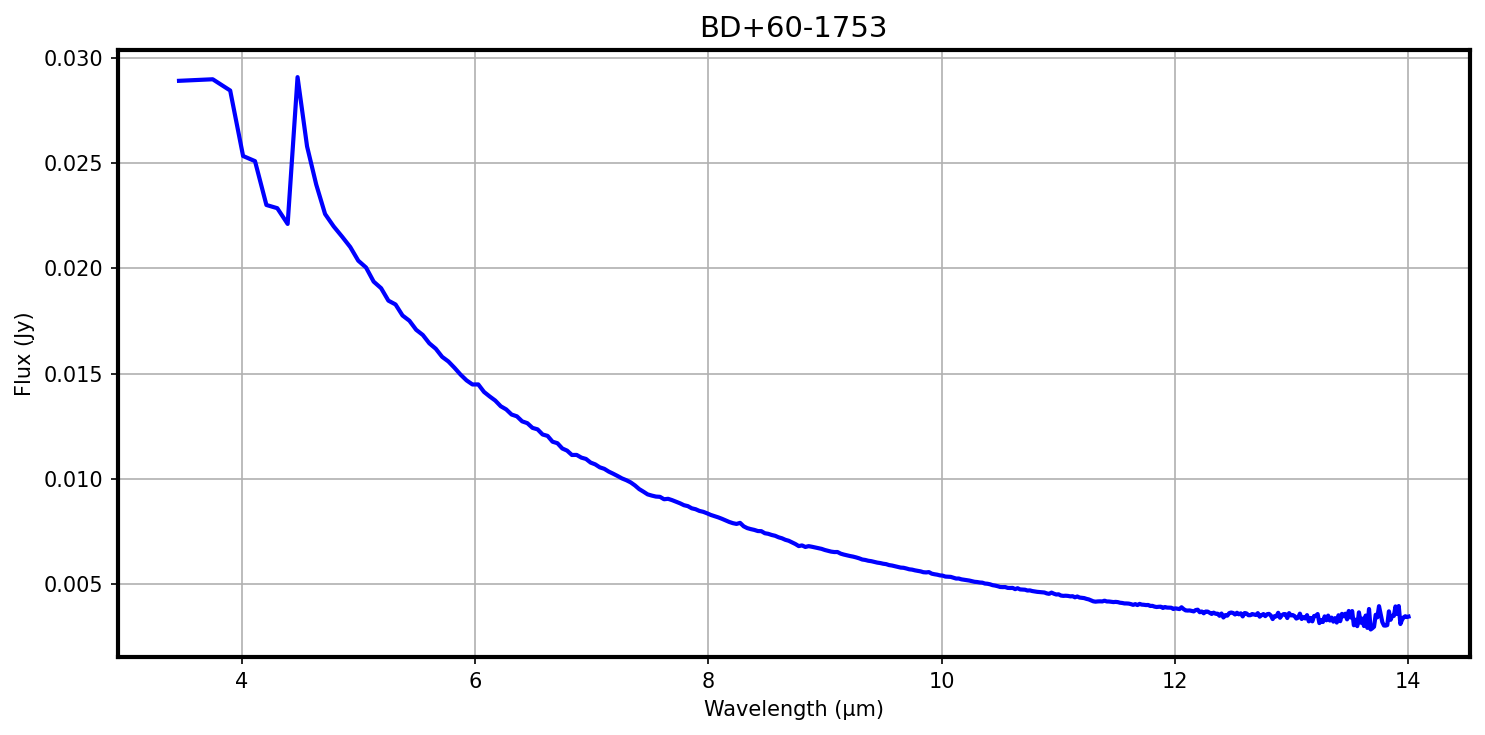

In [31]:
if do_viz:
    # Get Stage 3 extracted spectrum
    x1d_file = os.path.join(spec3_dir, 'Stage3_x1d.fits')
    hdu = fits.open(x1d_file)
    objname = hdu[0].header['TARGPROP']
    wave = hdu[1].data['WAVELENGTH']
    flux = hdu[1].data['FLUX']
    hdu.close()
    
    # Make normal plots
    %matplotlib inline
    # Interactive plots
    #%matplotlib notebook
    
    # Plot spectrum
    rc('axes', linewidth=2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
    ax.plot(wave, flux, 'b-', lw=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Flux (Jy)')
    plt.title(objname, fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(spec3_dir, 'lrs_slit_example_plot.png'))

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 